In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#installs

!pip install stellargraph
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#imports 

from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification, DeepGraphCNN
import pandas as pd
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

Creating custom graph dataset

In [ ]:
combined_phenotype='/content/drive/MyDrive/Capstone/COMBINED DATA/phenotypic_data.csv'
aug2_label = '/content/drive/MyDrive/Capstone/COMBINED DATA/aug2_labels.csv'
labels_mappings= pd.read_csv(combined_phenotype)
aug2_labels = pd.read_csv(aug2_label)

In [ ]:
def row_transform(arr, threshold):
  for i in range(len(arr)):
      arr[i] = arr[i] if arr[i]> threshold else abs(arr[i])+0.0001
  return arr

def binarize(df, threshold):
    df = df.transform(lambda x: row_transform(x, threshold))

In [ ]:
cb = '/content/drive/MyDrive/Capstone/COMBINED DATA/COBRE Binary'
cw = '/content/drive/MyDrive/Capstone/COMBINED DATA/COBRE Weighted'

ub = '/content/drive/MyDrive/Capstone/COMBINED DATA/UCLA Binary v2'
uw = '/content/drive/MyDrive/Capstone/COMBINED DATA/UCLA Weighted v2'

uba = '/content/drive/MyDrive/Capstone/Data Augmentation/UCLA Augmented Binary/UCLA Binary 0_2'
uwa = '/content/drive/MyDrive/Capstone/Data Augmentation/UCLA Augmented'

uba1 = '/content/drive/MyDrive/Capstone/Data Augmentation/UCLA Augmented Method 2 Binary/UCLA Binary 0_2'
uwa1 = '/content/drive/MyDrive/Capstone/Data Augmentation/UCLA Augmented Method 2'

weighted_features_aug = '/content/drive/MyDrive/Capstone/Data Augmentation/Local Weighted features - UCLA Aug/'
binary_features_aug = '/content/drive/MyDrive/Capstone/Data Augmentation/Local Binary features -  UCLA Aug/'

weighted_features_aug1 = '/content/drive/MyDrive/Capstone/Data Augmentation/Local Weighted features- UCLA Aug v2/'
binary_features_aug1 = '/content/drive/MyDrive/Capstone/Data Augmentation/Local Binary features - UCLA Aug v2/'

binary_features_02 = '/content/drive/MyDrive/Capstone/Graph properties /UCLA Binary Local 0_2/'
weighted_features = '/content/drive/MyDrive/Capstone/Graph properties /Weighted local feature files/'

In [ ]:
#0.25 threshold
ub_02 = '/content/drive/MyDrive/Capstone/COMBINED DATA/UCLA Binary 0_2/'
binary_features = '/content/drive/MyDrive/Capstone/Graph properties /UCLA Binary Local 0_2/'

In [ ]:
graphs_dir = [uba1, uba, ub_02]
# graphs_dir = [ub]
feat_dir = [(binary_features, "binary_node_features_ucla_binary_"), (weighted_features, "weighted_node_features_")]
aug_feat_dir = [(binary_features_aug, "binary_node_features_"), (weighted_features_aug, "weighted_node_features_")]
aug_feat_dir1 = [(binary_features_aug1, "binary_node_features_"), (weighted_features_aug1, "weighted_node_features_")]

In [ ]:
in_feat=0

In [ ]:
graphs = list()
graph_labels = list()

# Graph creation
for directory in graphs_dir:
  for file in os.listdir(directory):
    if '(' in file:
        continue
    if file.endswith('.csv'):
      if (directory == cb):
        subject = file[13:18]
      elif (directory == cw):
          subject = file[15:20]
      elif (directory == ub_02):
          subject = file[12:16]
          if int(subject) == 2155:
            continue
      elif (directory == uw):
          subject = file[14:18]
      elif (directory == uba):
          subject = file[12:16]
          if int(subject) < 3125:
            continue
      elif (directory == uba1):
          subject = file[12:16]
      else:
        print("INVALID DIRECTORY")
        exit(0)


      # APPENDING LABEL
      subject = int(subject)
      print(subject)
      mask = labels_mappings['Subject'] == subject
      #only for aug v2
      if directory ==  uba1:
        if(labels_mappings[mask]['Label'].values[0]==0 or 
            (labels_mappings[mask]['Label'].values[0]!=aug2_labels.query("Subject==@subject")["assumed"].values[0])):
            continue
      graph_labels.append(labels_mappings[mask]['Label'].values[0])

      # APPENDING CORRESPONDING GRAPH
      df = pd.read_csv(directory+'/'+file, header=None)
      df = df.fillna(0)
      if directory == uba:
        for col in df:
          df[col] = df[col].astype(np.int64)
      G = nx.from_pandas_adjacency(df)          

      # Features
      if directory == uba: 
        if len(feat_dir) == 1:
          node_data = pd.read_csv(aug_feat_dir[0][0]+aug_feat_dir[0][1]+str(subject)+'.csv')
          node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
        else: 
          node_data_1 = pd.read_csv(aug_feat_dir[0][0]+aug_feat_dir[0][1]+str(subject)+'.csv')
          node_data_2 = pd.read_csv(aug_feat_dir[1][0]+aug_feat_dir[1][1]+str(subject)+'.csv')
          node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True)
      elif directory == uba1:
        if len(feat_dir) == 1:
          node_data = pd.read_csv(aug_feat_dir1[0][0]+aug_feat_dir1[0][1]+str(subject)+'.csv')
          node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
        else: 
          node_data_1 = pd.read_csv(aug_feat_dir1[0][0]+aug_feat_dir1[0][1]+str(subject)+'.csv')
          node_data_2 = pd.read_csv(aug_feat_dir1[1][0]+aug_feat_dir1[1][1]+str(subject)+'.csv')
          node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True) 
      else:
        if len(feat_dir) == 1:
          node_data = pd.read_csv(feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
          node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
        else:
          node_data_1 = pd.read_csv(feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
          node_data_2 = pd.read_csv(feat_dir[1][0]+feat_dir[1][1]+str(subject)+'.csv')
          node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True)

      node_data = node_data.drop(['subgraph centrality'], axis=1, errors='ignore')
      in_feat = len(node_data.columns)

      # Standardisation
      cols = list(node_data)
      scaler = StandardScaler().fit(node_data)
      node_data = scaler.transform(node_data)
      node_data = pd.DataFrame(node_data, columns = cols)
      
      g = StellarGraph.from_networkx(G,node_features=node_data)
      graphs.append(g)

    #   print(subject)
    #   print(G)

4018
4021
4023
4014
4016
4019
4024
4022
4025
4009
4017
4000
4001
4006
4015
4005
4002
4003
4013
4008
4010
4007
4020
4004
4011
4012
4041
4043
4061
4066
4034
4032
4051
4069
4067
4029
4035
4037
4028
4039
4062
4060
4038
4058
4047
4055
4072
4075
4050
4048
4074
4042
4068
4026
4073
4057
4054
4064
4052
4033
4030
4045
4071
4040
4056
4065
4063
4053
4031
4070
4036
4059
4027
4049
4044
4046
4098
4113
4103
4107
4077
4120
4100
4109
4080
4086
4091
4078
4079
4093
4112
4111
4090
4089
4104
4101
4108
4087
4083
4097
4123
4118
4117
4114
4124
4085
4099
4102
4116
4084
4119
4096
4088
4106
4105
4121
4094
4125
4092
4082
4110
4081
4115
4122
4095
4147
4076
4169
4129
4128
4144
4150
4141
4142
4154
4165
4143
4146
4151
4137
4161
4156
4157
4133
4135
4167
4136
4168
4164
4127
4170
4148
4171
4166
4153
4158
4159
4139
4162
4145
4163
4149
4140
4130
4134
4126
4131
4160
4155
4138
4152
4132
3125
3126
3129
3128
3130
3133
3131
3135
3132
3134
3136
3138
3137
3139
3140
3141
3142
3144
3143
3146
3145
3148
3149
3147
3151
3152
3154
3155


In [ ]:
graph_labels = pd.DataFrame(graph_labels)

In [ ]:
# graph_labels.value_counts().to_frame()

In [ ]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

### DGCNN Model

In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

In [ ]:
rs_list = [5,20,21,34,40,45,75,69]

In [ ]:
from sklearn import metrics
acc = []
pre = []
re = []
spe = []
f = []
es = EarlyStopping(monitor="val_acc", min_delta=0, patience=30, restore_best_weights=True)
epochs=100
for rs in rs_list:
    k = 20 
    in_feat = 20
    layer_sizes = [in_feat, 32, 64, 128, 128, 64, 32, 16, 4, 2]
    dgcnn_model = DeepGraphCNN(
        layer_sizes=layer_sizes,
        activations=["leaky_relu", "leaky_relu", "leaky_relu",  "leaky_relu", "leaky_relu", "leaky_relu", 
                        "leaky_relu", "leaky_relu", "leaky_relu", "softmax"],
        k=k,
        bias=True,
        generator=generator,
    )
    x_inp, x_out = dgcnn_model.in_out_tensors()

    x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
    x_out = MaxPool1D(pool_size=2)(x_out)
    x_out = Conv1D(filters=32, kernel_size=4, strides=1)(x_out)
    x_out = Flatten()(x_out)
    x_out = Dense(units=128, activation="leaky_relu")(x_out)
    x_out = Dropout(rate=0.5)(x_out)

    predictions = Dense(units=1, activation="sigmoid")(x_out)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=binary_crossentropy, metrics=["acc"],)

    train_graphs, test_graphs = model_selection.train_test_split(graph_labels, train_size=0.8, test_size=0.2, stratify=graph_labels, random_state=rs)
    gen = PaddedGraphGenerator(graphs=graphs)

    train_gen = gen.flow(
        list(train_graphs.index - 1),
        targets=train_graphs.values,
        batch_size=50,
        symmetric_normalization=True,
    )

    test_gen = gen.flow(
        list(test_graphs.index - 1),
        targets=test_graphs.values,
        batch_size=1,
        symmetric_normalization=True,
    )

    history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True, callbacks=[es],)
    test_metrics = model.evaluate(test_gen)

    pred = model.predict(test_gen)

    y_pred = []
    y_true = []
    x = np.array(pred)
    for i in x:
        if i <0.5:
            y_pred.append(0)
        else:
            y_pred.append(1)

    for t in test_gen.targets:
        y_true.append(t[0])

    f1_score = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall =  metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    print(rs)
    print("Metrics:")
    print("Accuracy: ", accuracy)
    print("f1 score: ", f1_score)
    print("precision: ", precision)
    print("recall: ", recall)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    print("Specificity", specificity)

    acc.append(accuracy)
    f.append(f1_score)
    pre.append(precision)
    re.append(recall)
    spe.append(specificity)

    print('\n\n')

print('Average accccuracy: %.3f +/- %.3f' %(np.mean(acc), np.std(acc)))
print('Average precision: %.3f +/- %.3f' %(np.mean(pre), np.std(pre)))
print('Average recall: %.3f +/- %.3f' %(np.mean(re), np.std(re)))
print('Average f1: %.3f +/- %.3f \n\n' %(np.mean(f), np.std(f)))
print('Average specificity: %.3f +/- %.3f \n\n' %(np.mean(spe), np.std(spe)))

Epoch 1/100
4/4 [==============================] - 7s 954ms/step - loss: 0.6940 - acc: 0.5051 - val_loss: 0.6947 - val_acc: 0.5000
Epoch 2/100
4/4 [==============================] - 2s 500ms/step - loss: 0.6995 - acc: 0.4796 - val_loss: 0.6922 - val_acc: 0.5800
Epoch 3/100
4/4 [==============================] - 1s 391ms/step - loss: 0.6870 - acc: 0.5510 - val_loss: 0.6921 - val_acc: 0.5400
Epoch 4/100
4/4 [==============================] - 2s 492ms/step - loss: 0.6960 - acc: 0.4745 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 5/100
4/4 [==============================] - 2s 397ms/step - loss: 0.6940 - acc: 0.5051 - val_loss: 0.6900 - val_acc: 0.6000
Epoch 6/100
4/4 [==============================] - 2s 503ms/step - loss: 0.6943 - acc: 0.4898 - val_loss: 0.6898 - val_acc: 0.6600
Epoch 7/100
4/4 [==============================] - 2s 404ms/step - loss: 0.6925 - acc: 0.5153 - val_loss: 0.6894 - val_acc: 0.6000
Epoch 8/100
4/4 [==============================] - 2s 492ms/step - loss: 0.6963 - a

In [ ]:
from stellargraph.interpretability.saliency_maps import IntegratedGradients

Best RS from 40 to 80:  

62 really good rec, but others not so good 
51(p good) 

75, 69    
all 80

73 (one of the best)  
acc- 0.84   
f1- 0.86   
prec- 0.94    
rec- 0.76    
spec- 0.96  

55  
acc- 0.8    
f1- 0.82   
prec- 0.742  
rec- 0.92   
spec- 0.68    

40  
acc- 0.84  
f1- 0.8333  
prec- 0.87  
rec- 0.80  
spec- 0.88  


45  
acc- 0.82   
f1- 0.75  
prec- 1.0  
rec- 0.62  
spec- 1.0  



iter 1:

Accuracy:  0.86 <br>
f1 score:  0.8627450980392156<br>
precision:  0.8461538461538461<br>
recall:  0.88<br>
specificity: 0.84 <br>

iter 4: <br>
Accuracy:  0.86 <br>
f1 score:  0.8627450980392156 <br>
precision:  0.8461538461538461 <br>
recall:  0.88 <br>
specificity  0.84 <br>

iter 6: <br>
Accuracy:  0.78 <br>
f1 score:  0.7843137254901961 <br>
precision:  0.7692307692307693 <br>
recall:  0.8 <br>
specificity  0.76 <br>

iter 7: <br>
Accuracy:  0.78 <br>
f1 score:  0.8070175438596492 <br>
precision:  0.7875 <br>
recall:  0.92 <br>
specificity  0.68 <br>

iter 9: <br>
Accuracy:  0.82 <br>
f1 score:  0.7999999999999999 <br>
precision:  0.8 <br>
recall:  0.92 <br>
specificity  0.79 <br>

77  
acc- 0.76    
f1- 0.80    
prec- 0.70   
rec- 0.92   
spec- 0.62    

In [ ]:
acc = [0.76,0.82, 0.78, 0.78, 0.86, 0.86, 0.82, 0.84, 0.80, 0.84 ]
print("acc")
print(np.mean(acc), "±", np.std(acc) )

f1 = [0.70, 0.80, 0.79, 0.80, 0.79, 0.86, 0.75, 0.83, 0.82, 0.86]
print("f1")
print(np.mean(f1), "±",  np.std(f1))

prec = [0.8, 0.78, 0.80, 0.76, 0.84, 0.85, 1.0, 0.87, 0.742, 0.94]
print("prec")
print(np.mean(prec), "±", np.std(prec) )

rec = [0.76, 0.92, 0.80, 0.92, 0.80, 0.88, 0.88, 0.80, 0.92, 0.92, 0.92]
print("rec")
print(np.mean(rec), "±" , np.std(rec))

spec = [0.80, 0.96, 0.88, 1.0 , 0.84, 0.84, 0.76, 0.72, 0.79, 0.80]
print("spec")
print(np.mean(spec), "±" , np.std(spec))

acc
0.8160000000000001 ± 0.03322649545167228
f1
0.8 ± 0.04604345773288535
prec
0.8382 ± 0.07705296879420025
rec
0.8654545454545456 ± 0.059751551727836305
spec
0.8390000000000001 ± 0.08251666498350499



iter 5: <br>
Accuracy:  0.78  <br>
f1 score:  0.7886206896551725  <br>
precision:  0.698 <br>
recall:  0.88  <br>
specificity  0.66  <br>

# Split brain

In [ ]:
rs=10

RS splits for augmented <br>
1,4,5(best),10,17,18,20(best),21(best), 24, 25, 32, 34(best yet)

In [ ]:
es = EarlyStopping(monitor="val_acc", min_delta=0, patience=30, restore_best_weights=True)

In [ ]:
k = 20 
in_feat = 20
layer_sizes = [in_feat, 32, 64, 128, 128, 64, 32, 16, 4, 2]
dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["leaky_relu", "leaky_relu", "leaky_relu",  "leaky_relu", "leaky_relu", "leaky_relu", "leaky_relu", "leaky_relu", "leaky_relu", "log_softmax"],
    k=k,
    bias=True,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)
x_out = Conv1D(filters=32, kernel_size=4, strides=1)(x_out)
x_out = Flatten()(x_out)
x_out = Dense(units=128, activation="leaky_relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
epochs=100

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=0.0005), loss=binary_crossentropy, metrics=["acc"],
)

train_graphs, test_graphs = model_selection.train_test_split(graph_labels, train_size=0.8, test_size=0.2, stratify=graph_labels, random_state=rs)
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=True,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=True,
)

history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True, callbacks=[es],)
test_metrics = model.evaluate(test_gen)

Epoch 1/100
4/4 [==============================] - 7s 1s/step - loss: 0.6949 - acc: 0.4694 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 2/100
4/4 [==============================] - 2s 421ms/step - loss: 0.6887 - acc: 0.5918 - val_loss: 0.6908 - val_acc: 0.7200
Epoch 3/100
4/4 [==============================] - 2s 519ms/step - loss: 0.6861 - acc: 0.5255 - val_loss: 0.6913 - val_acc: 0.5000
Epoch 4/100
4/4 [==============================] - 2s 434ms/step - loss: 0.6937 - acc: 0.5102 - val_loss: 0.6912 - val_acc: 0.5200
Epoch 5/100
4/4 [==============================] - 2s 687ms/step - loss: 0.6959 - acc: 0.5357 - val_loss: 0.6904 - val_acc: 0.6000
Epoch 6/100
4/4 [==============================] - 3s 703ms/step - loss: 0.6963 - acc: 0.5153 - val_loss: 0.6894 - val_acc: 0.5000
Epoch 7/100
4/4 [==============================] - 2s 517ms/step - loss: 0.6960 - acc: 0.4949 - val_loss: 0.6885 - val_acc: 0.5400
Epoch 8/100
4/4 [==============================] - 2s 422ms/step - loss: 0.6857 - acc:

In [ ]:
print("\nTest Set Metrics:")

print("Validation Accuracy: ", max(history.history['val_acc']))
print("Validation Loss: ", min(history.history['val_loss']))


Test Set Metrics:
Validation Accuracy:  0.699999988079071
Validation Loss:  0.559349775314331


In [ ]:
print("\nTraining Set Metrics:")

print("Accuracy: ", max(history.history['acc']))
print("Loss: ", min(history.history['loss']))


Training Set Metrics:
Accuracy:  0.8418367505073547
Loss:  0.4243176579475403


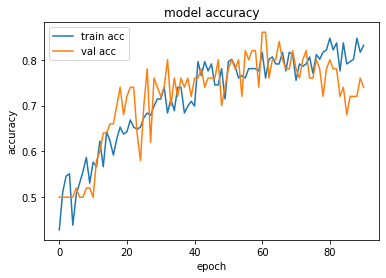

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(test_gen)

50/50 [==============================] - 1s 7ms/step


In [ ]:
y_pred = []
y_true = []
x = np.array(pred)
for i in x:
  if i <0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

for t in test_gen.targets:
    y_true.append(t[0])

In [ ]:
from sklearn import metrics

f1_score = metrics.f1_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall =  metrics.recall_score(y_true, y_pred)
accuracy = metrics.accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)

In [ ]:
print("Metrics:")

print("Accuracy: ", accuracy)
print("f1 score: ", f1_score)
print("precision: ", precision)
print("recall: ", recall)
print("specificity ", specificity)

Metrics:
Accuracy:  0.82
f1 score:  0.7999999999999999
precision:  0.9
recall:  0.72
specificity  0.92


Acc: 80.4 +- 4.5 <br>
f1: 79.0 +- 4.4 <br>
precision: <br>
recall: <br>
specificity: <br>


In [ ]:
acc = [ 0.86, 0.72, 0.75, 0.863, 0.789, 0.78, 0.8, 0.79, 0.76 ]
np.std (acc)

0.04450911960930099

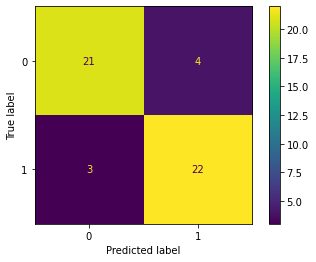

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0,1])
disp.plot()

In [ ]:
roc_auc_score(y_true, y_pred)

0.86